In [2]:
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import wrds
from dateutil.relativedelta import relativedelta

from settings import config

DATA_DIR = Path(config("DATA_DIR"))
WRDS_USERNAME = config("WRDS_USERNAME")
START_DATE = datetime.strptime("2021-10-01", "%Y-%m-%d")
END_DATE = datetime.strptime("2024-05-31", "%Y-%m-%d")

db = wrds.Connection(wrds_username=WRDS_USERNAME)

Loading library list...
Done


In [63]:
def pull_ravenpack(wrds_username=WRDS_USERNAME):
    print("Pulling Ravenpack data from WRDS...")

    query = """
    WITH id AS (
      SELECT rp_entity_id, entity_type, entity_name, ticker, cusip, isin
      FROM ravenpack_common.wrds_rpa_company_mappings
    ),
    rp AS (
      SELECT * FROM ravenpack_dj.rpa_djpr_equities_2021
      UNION ALL
      SELECT * FROM ravenpack_dj.rpa_djpr_equities_2022
      UNION ALL
      SELECT * FROM ravenpack_dj.rpa_djpr_equities_2023
      UNION ALL
      SELECT * FROM ravenpack_dj.rpa_djpr_equities_2024
    ),
    ranked AS (
      SELECT
        rp.*,
        id.entity_type AS map_entity_type,
        id.entity_name AS map_entity_name,
        id.ticker      AS map_ticker,
        id.cusip       AS map_cusip,
        id.isin        AS map_isin,
        ROW_NUMBER() OVER (
          PARTITION BY rp.rp_entity_id, rp.event_similarity_key
          ORDER BY rp.timestamp_utc
        ) AS rn
      FROM rp
      LEFT JOIN id
        ON rp.rp_entity_id = id.rp_entity_id
      WHERE rp.rpa_date_utc BETWEEN DATE '2021-10-01' AND DATE '2024-05-31'
        AND rp.relevance = 100
    )
    SELECT *
    FROM ranked
    WHERE rn = 1;
    """

    db = wrds.Connection(wrds_username=wrds_username)
    df = db.raw_sql(query)
    db.close()
    return df


In [57]:
def pull_ravenpack(
    wrds_username=WRDS_USERNAME
):
    print("Pulling Ravenpack data from WRDS...")

    query = (f"""
        SELECT rp.*,
              -- mapping table columns (renamed to avoid collisions)
              id.entity_type AS map_entity_type, 
             id.entity_name AS map_entity_name, 
             id.ticker AS map_ticker, 
             id.cusip AS map_cusip, 
             id.isin AS map_isin 
        FROM ravenpack_dj.rpa_djpr_equities_2021 rp 
        LEFT JOIN ravenpack_common.wrds_rpa_company_mappings id 
        ON rp.rp_entity_id = id.rp_entity_id 
        WHERE rp.rpa_date_utc BETWEEN DATE '2021-10-01' AND DATE '2025-05-31' 
        AND rp.event_relevance = 100
        AND rp.relevance = 100
    """)
    
    df = db.raw_sql(query)
    db.close()
    return df


In [3]:
    df = load_ravenpack()
    print("Saving Ravenpack data to parquet file...")
    path = Path(DATA_DIR) / "RAVENPACK.parquet"
    df.to_parquet(path)

NameError: name 'load_ravenpack' is not defined

In [65]:
df.shape

(1738788, 58)

In [66]:
df.tail(5).T

,238783,238784,238785,238786,238787
rpa_date_utc,2023-03-13,2024-02-26,2024-03-26,2023-03-13,2023-08-21
rpa_time_utc,12:30:07,12:06:13,11:00:19,12:30:07,11:30:05
timestamp_utc,2023-03-13 12:30:07.068000,2024-02-26 12:06:13.380000,2024-03-26 11:00:19.185000,2023-03-13 12:30:07.068000,2023-08-21 11:30:04.960000
rp_story_id,1F97173F99B6072B84436D141582F2AF,BCAC4793CBED8A9CE638A973DB529074,C3C7EB187F39747A48BBEACD56324405,1F97173F99B6072B84436D141582F2AF,99A7FE1D88084136B2151A7B52342648
rp_entity_id,WZXP28,WZXP28,WZXP28,WZXP28,WZXP28
entity_type,COMP,COMP,COMP,COMP,COMP
entity_name,Freightos Ltd.,Freightos Ltd.,Freightos Ltd.,Freightos Ltd.,Freightos Ltd.
country_code,KY,KY,KY,KY,KY
relevance,100.0,100.0,100.0,100.0,100.0
event_sentiment_score,0.0,0.0,0.49,-0.63,0.0


In [55]:
df['rp_entity_id'].nunique()

9139

In [56]:
df['event_relevance'].nunique()


41

In [67]:
df.columns

Index(['rpa_date_utc', 'rpa_time_utc', 'timestamp_utc', 'rp_story_id',
       'rp_entity_id', 'entity_type', 'entity_name', 'country_code',
       'relevance', 'event_sentiment_score', 'event_relevance',
       'event_similarity_key', 'event_similarity_days', 'topic', 'group',
       'type', 'sub_type', 'property', 'fact_level', 'rp_position_id',
       'position_name', 'evaluation_method', 'maturity', 'earnings_type',
       'event_start_date_utc', 'event_end_date_utc', 'reporting_period',
       'reporting_start_date_utc', 'reporting_end_date_utc', 'related_entity',
       'relationship', 'category', 'event_text', 'news_type', 'rp_source_id',
       'source_name', 'css', 'nip', 'peq', 'bee', 'bmq', 'bam', 'bca', 'ber',
       'anl_chg', 'mcq', 'rp_story_event_index', 'rp_story_event_count',
       'product_key', 'provider_id', 'provider_story_id', 'headline',
       'map_entity_type', 'map_entity_name', 'map_ticker', 'map_cusip',
       'map_isin', 'rn'],
      dtype='object')

In [70]:
from rapidfuzz import fuzz

import re

def _norm(s):
    return re.sub(r"\s+", " ", (s or "").lower()).strip()

def dedupe_group(g, threshold=60):
    g = g.sort_values(
        ["event_relevance", "timestamp_utc"],
        ascending=[False, True]
    )

    kept_norms = []
    keep_rows = []

    for _, row in g.iterrows():
        h = _norm(row["headline"])
        if not any(
            fuzz.token_set_ratio(h, kh) > threshold
            for kh in kept_norms
        ):
            kept_norms.append(h)
            keep_rows.append(row)

    return pd.DataFrame(keep_rows)

df_filter = (
    df.groupby(['rp_entity_id', 'rpa_date_utc'], group_keys=False)
      .apply(dedupe_group)
)

/var/folders/rp/j9qm6mtx7f5b20_xmh3k0zjr0000gn/T/ipykernel_43643/149615780.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(dedupe_group)


In [71]:
df_filter.shape

(896365, 58)

In [1]:
df_filter.tail(5).T

NameError: name 'df_filter' is not defined

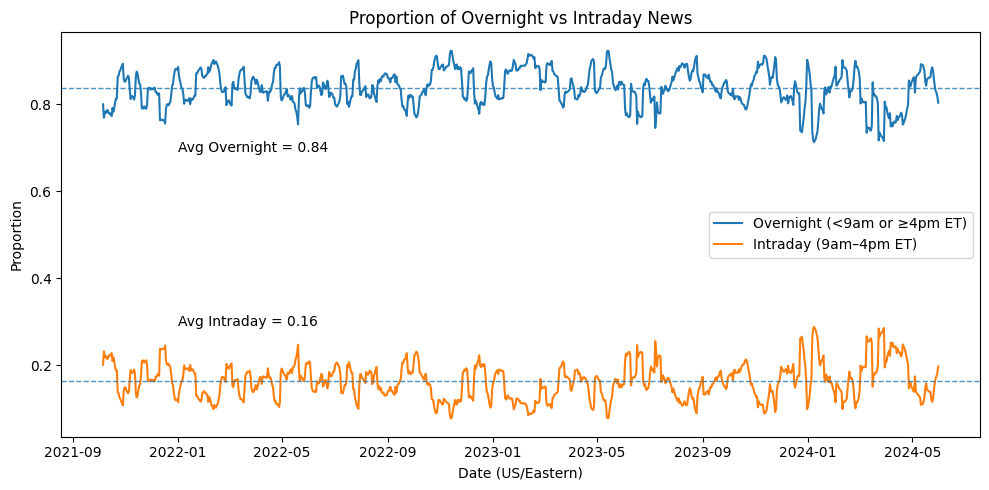

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

# -----------------------------
# set hours (same as paper)
# -----------------------------
MARKET_OPEN_HOUR = 9    # 9:00am ET
MARKET_CLOSE_HOUR = 16  # 4:00pm ET
ROLLING_DAYS = 7        # set to None or 0 to disable smoothing

# -----------------------------
# load ravenapack data
# -----------------------------
df = pd.read_parquet(DATA_DIR / "RAVENPACK.parquet")

# fixing timestamps and converting to ET
ts = pd.to_datetime(df["timestamp_utc"], errors="coerce")

if ts.dt.tz is None:
    ts = ts.dt.tz_localize("UTC")

ts_et = ts.dt.tz_convert("America/New_York")

# Build ET date + hour
df["date_et"] = ts_et.dt.date
hour_et = (
    ts_et.dt.hour
    + ts_et.dt.minute / 60.0
    + ts_et.dt.second / 3600.0
)

# Overnight definition
df["is_overnight"] = (hour_et < MARKET_OPEN_HOUR) | (hour_et >= MARKET_CLOSE_HOUR)

# -----------------------------
# Daily proportions
# -----------------------------
daily = (
    df.groupby("date_et")["is_overnight"]
      .agg(n_total="size", n_overnight="sum")
      .sort_index()
)

daily["p_overnight"] = daily["n_overnight"] / daily["n_total"]
daily["p_intraday"] = 1.0 - daily["p_overnight"]

plot_df = daily[["p_overnight", "p_intraday"]].copy()

if ROLLING_DAYS and ROLLING_DAYS > 1:
    plot_df = plot_df.rolling(ROLLING_DAYS, min_periods=ROLLING_DAYS).mean()

# -----------------------------
# Plot
# -----------------------------
ax = plot_df.plot(figsize=(10, 5))

ax.set_title("Proportion of Overnight vs Intraday News")
ax.set_xlabel("Date (US/Eastern)")
ax.set_ylabel("Proportion")
ax.legend(["Overnight (<9am or ≥4pm ET)", "Intraday (9am–4pm ET)"])

# -----------------------------
# Averages
# -----------------------------
avg_overnight = plot_df["p_overnight"].mean()
avg_intraday = plot_df["p_intraday"].mean()

ax.axhline(avg_overnight, linestyle="--", linewidth=1, alpha=0.8)
ax.axhline(avg_intraday, linestyle="--", linewidth=1, alpha=0.8)

label_x = pd.Timestamp("2022-01-01")

ax.text(
    label_x,
    0.70,
    f"Avg Overnight = {avg_overnight:.2f}",
    ha="left",
    va="center",
    fontsize=10
)

ax.text(
    label_x,
    0.30,
    f"Avg Intraday = {avg_intraday:.2f}",
    ha="left",
    va="center",
    fontsize=10
)

plt.tight_layout()
plt.show()

In [76]:
from pathlib import Path

import pandas as pd
import plotly.express as px

from settings import config

DATA_DIR = Path(config("DATA_DIR"))
OUTPUT_DIR = Path(config("OUTPUT_DIR"))

MARKET_OPEN_HOUR = 9
MARKET_CLOSE_HOUR = 16
ROLLING_DAYS = 7  # set to 0/None to disable


df = pd.read_parquet(DATA_DIR / "RAVENPACK.parquet")

ts = pd.to_datetime(df["timestamp_utc"], errors="coerce")
if ts.dt.tz is None:
    ts = ts.dt.tz_localize("UTC")
ts_et = ts.dt.tz_convert("America/New_York")

df["date_et"] = ts_et.dt.date
hour_et = ts_et.dt.hour + ts_et.dt.minute / 60.0 + ts_et.dt.second / 3600.0
df["is_overnight"] = (hour_et < MARKET_OPEN_HOUR) | (hour_et >= MARKET_CLOSE_HOUR)

daily = (
    df.groupby("date_et")["is_overnight"]
      .agg(n_total="size", n_overnight="sum")
      .sort_index()
)
daily["p_overnight"] = daily["n_overnight"] / daily["n_total"]
daily["p_intraday"] = 1.0 - daily["p_overnight"]

plot_df = daily[["p_overnight", "p_intraday"]].copy()
if ROLLING_DAYS and ROLLING_DAYS > 1:
    plot_df = plot_df.rolling(ROLLING_DAYS, min_periods=ROLLING_DAYS).mean()

plot_long = (
    plot_df.reset_index()
          .melt(id_vars="date_et", var_name="series", value_name="proportion")
)

series_name = {
    "p_overnight": "Overnight (<9am or ≥4pm ET)",
    "p_intraday": "Intraday (9am–4pm ET)",
}
plot_long["series"] = plot_long["series"].map(series_name)

avg_overnight = plot_df["p_overnight"].mean()
avg_intraday = plot_df["p_intraday"].mean()

fig = px.line(
    plot_long,
    x="date_et",
    y="proportion",
    color="series",
    title="Proportion of Overnight vs Intraday News",
    labels={"date_et": "Date (US/Eastern)", "proportion": "Proportion", "series": ""},
)

# Average reference lines + left-anchored annotations
fig.add_hline(y=avg_overnight, line_dash="dash")
fig.add_hline(y=avg_intraday, line_dash="dash")

fig.add_annotation(
    x="2022-01-01", y=0.70, xref="x", yref="y",
    text=f"Avg Overnight = {avg_overnight:.2f}",
    showarrow=False, xanchor="left"
)
fig.add_annotation(
    x="2022-01-01", y=0.30, xref="x", yref="y",
    text=f"Avg Intraday = {avg_intraday:.2f}",
    showarrow=False, xanchor="left"
)
